# Plaquette energy vs beta

Replication of Gattringer and Lang page 99) 10 hits is IMPORTANT, so is number of su3 matrices 100+ give bigger values (wrong) for energy as well as no of correlation 

In [1]:
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt
from functools import partial
%matplotlib inline

def generate_su2(epsilon):
    #generates a random su2 matrix where epsilon controls the "distance" from the identity
    r_random_numbers = np.random.uniform(0, 0.5, (4))
    r = np.empty((4))
    
    r[1:] = epsilon * r_random_numbers[1:] / np.linalg.norm(r_random_numbers[1:])
    r[0] = np.sign(r_random_numbers[0]) * np.sqrt(1-epsilon**2)
    
    r11 = r[0] + r[3]*1j
    r12 = r[1]*1j + r[2]
    r21 = r[1]*1j - r[2]
    r22 = r[0] - r[3]*1j
    
    return np.array([[r11, r12], [r21, r22]])
    
def generate_su3_array(n, epsilon):
    #generates a 2*n array of su3 matrices where epsilon controls the distance from the idenity
    su3_array = np.empty((2*n, 3, 3), dtype = 'complex128')
    
    for i in range(n):

        R_su3 = np.identity(3, dtype=complex)
        S_su3 = np.identity(3, dtype=complex)
        T_su3 = np.identity(3, dtype=complex)

        R_su3[:2, :2] = generate_su2(epsilon)
        S_su3[0:3:2, 0:3:2] = generate_su2(epsilon)
        T_su3[1:, 1:] = generate_su2(epsilon)
        
        X_su3 = np.dot(np.dot(R_su3, S_su3), T_su3)

        su3_array[2*i, :, :] = X_su3
        su3_array[2*i+1, :, :] = X_su3.conj().T
        
    return su3_array

### Classes for the lattice and the site at each lattice point.

Site value is just a scalar here as this is a simple gauge simulation. The fundamental data structure of the lattice is a numpy array of site objects which have four links initialised to the identity matrix.

In [2]:
def generate_site():
    #Returns a 4 dimensional array of su3 matrices initialised to the identity which can be assigned to each
    #spatial lattice point
    link_value = np.identity(3, dtype = 'complex128')
    link = np.tile(link_value, (4, 1, 1))
    
    return link
        

def generate_lattice(n_points):
    #Returns a (n_points, n_points, n_points, n_points, 4, 3, 3) numpy array as our lattice with 4
    #su3 links assigned to each grid point
    volume = np.append(np.repeat(n_points, 4), (4,3,3))
    grid = np.empty(volume, dtype = 'complex128')
    
    for t in range(n_points):
        for x in range(n_points):
            for y in range(n_points):
                for z in range(n_points):
                    grid[t, x, y, z, :, :, :] = generate_site()
                        
    return grid

def link(lattice, coordinates, mu):
    #Function to take into account periodic bd conditions
    n_points = lattice.shape[0]
        
    return lattice[coordinates[0] % n_points, coordinates[1] % n_points, 
                   coordinates[2] % n_points, coordinates[3] % n_points, mu, : , :]

In [3]:
def wilson_link_sum(lattice, coordinates,  mu, u_0):
    #Staple sum for the wilson plaquette action
    dimension = 4
    res = np.zeros((3,3), dtype = 'complex128')
    
    for nu in range(dimension):
        if nu != mu:
            
            coordinates_mu = coordinates[:]
            coordinates_mu[mu] += 1
            
            coordinates_nu = coordinates[:]
            coordinates_nu[nu] += 1
            
            coordinates_mu_n_nu = coordinates[:]
            coordinates_mu_n_nu[mu] += 1
            coordinates_mu_n_nu[nu] -= 1
            
            coordinates_n_nu = coordinates[:]
            coordinates_n_nu[nu] -= 1
            
            #1x1 positive
            res += np.dot(np.dot(link(lattice, coordinates_mu, nu), 
                                 link(lattice, coordinates_nu, mu).conj().T),
                                 link(lattice, coordinates,    nu).conj().T)
            #1x1 negative
            res += np.dot(np.dot(link(lattice, coordinates_mu_n_nu, nu).conj().T, 
                                 link(lattice, coordinates_n_nu,    mu).conj().T), 
                                 link(lattice, coordinates_n_nu,    nu))
        
    return res / u_0**4 / 3

In [4]:
def update_link(lattice, coordinates, mu, link_sum, su3_set, su3_set_length, beta, u_0, n_hits):
    
    accept = 0
    
    t = coordinates[0]
    x = coordinates[1]
    y = coordinates[2]
    z = coordinates[3]
    
    #compute staple once for given link
    staple = link_sum(lattice, coordinates,  mu, u_0)
    
    #update single link multiple times to bring into equilibrium with surrounding links
    for i in range(n_hits):

        su3_matrix = su3_set[np.random.randint(0, su3_set_length)]
        
        new_link = np.dot(su3_matrix , lattice[t, x, y, z, mu, : , :])
        
        diff = new_link - lattice[t, x, y, z, mu, : , :]
    
        deltaS = beta * np.trace(np.dot(diff, staple)).real
    
        if np.exp(deltaS) > np.random.rand():
          
            lattice[t, x, y, z, mu, : , :] = new_link
            accept += 1
    
    return accept / n_hits

In [5]:
def update_lattice(lattice, link_sum, su3_set, beta, u_0, n_hits):
    n_points = lattice.shape[0]
    dimension = 4 
    acceptance = 0
    su3_set_length = len(su3_set)
    
    for t in range(n_points):
        for x in range(n_points):
            for y in range(n_points):
                for z in range(n_points):
                    for mu in range(dimension):
                        acceptance += update_link(lattice, [t,x,y,z], mu, link_sum, 
                                                  su3_set, su3_set_length, beta, u_0, n_hits)
                            
    return acceptance / dimension / n_points**dimension

In [6]:
def markov_chain(lattice, link_sum,  su3_set, beta, u_0, n_configs, n_corr, n_hits, 
                 thermal_steps = 100, thermalise = True):
    
    acceptance = 0
    ensemble = []
    
    #Thermalise
    if thermalise == True:
        for i in range(int(thermal_steps)):
            
            update_lattice(lattice, link_sum, su3_set, beta, u_0, n_hits=n_hits)
    
    #Equilibrium Update
    for j in range(n_configs*n_corr):
        
        acceptance += update_lattice(lattice, link_sum, su3_set, beta, u_0, n_hits=n_hits)
        
        if j % n_corr == 0:
            
            ensemble.append(lattice)
    
    if n_configs != 0 and n_corr != 0:
    
        acceptance = acceptance / n_configs / n_corr       
    
    return ensemble, acceptance

### Plaquette lattice average

In [7]:
def square_wilson_loop(lattice, coordinates, mu, nu):
    #compute upper plaquette
    coordinates_mu = coordinates[:]
    coordinates_mu[mu] +=1
    coordinates_nu = coordinates[:]
    coordinates_nu[nu] +=1
    
    res = np.dot(np.dot(np.dot(link(lattice, coordinates,    mu), 
                               link(lattice, coordinates_mu, nu)), 
                               link(lattice, coordinates_nu, mu).conj().T), 
                               link(lattice, coordinates,    nu).conj().T)
        
    return np.trace(res).real / 3


def square_lattice_average(lattice):
    #average plaquette over whole lattice
    dimension = 4
    unique_2d_loops_number = 6
    n_points = lattice.shape[0]
    
    res = 0
    for t in range(n_points):
        for x in range(n_points):
            for y in range(n_points):
                for z in range(n_points):
                    for mu in range(dimension):
                        for nu in range(mu):
                            res += square_wilson_loop(lattice, [t,x,y,z], mu, nu)
                                
    return res / n_points**dimension / unique_2d_loops_number

In [8]:
def gauge_average(lattice_ensemble, loop_average_function):

    loop_ensemble = list(map(loop_average_function, lattice_ensemble))
        
    return np.mean(loop_ensemble), np.std(loop_ensemble) / np.sqrt(len(lattice_ensemble))

In [9]:
su3_array = generate_su3_array(25, epsilon = 0.2)

In [10]:
def plaquette_energy_thermal(thermal_steps, hits):
    
    latt = generate_lattice(n_points = 6)

    ensemble, acceptance1 = markov_chain(lattice = latt, link_sum = wilson_link_sum, su3_set = su3_array, 
                                         beta = 5.5, u_0 = 1, n_configs = 10, n_corr = 50, n_hits = hits, 
                                         thermal_steps = thermal_steps)
    
    wilson_square_loop = gauge_average(ensemble, square_lattice_average)[0]
    
    del latt
    
    return wilson_square_loop


def plaquette_plot_thermal(hits):
    
    
    plaq_func = partial(plaquette_energy_thermal, hits = hits)
    p = Pool(5)
    thermal_arr = np.linspace(10, 500, 20)
    energy_array = p.map(plaq_func, thermal_arr)
    p.terminate()
    
    f, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.plot(thermal_arr, energy_array, 'g^')
    ax.set_title('Plaquette value vs thermalise steps')
    ax.set_xlabel("Thermalise Steps")
    ax.set_ylabel("Plaquette Energy")
    plt.show()
    
    return energy_array

### Plaquette energy vs thermalsteps for 10 hits

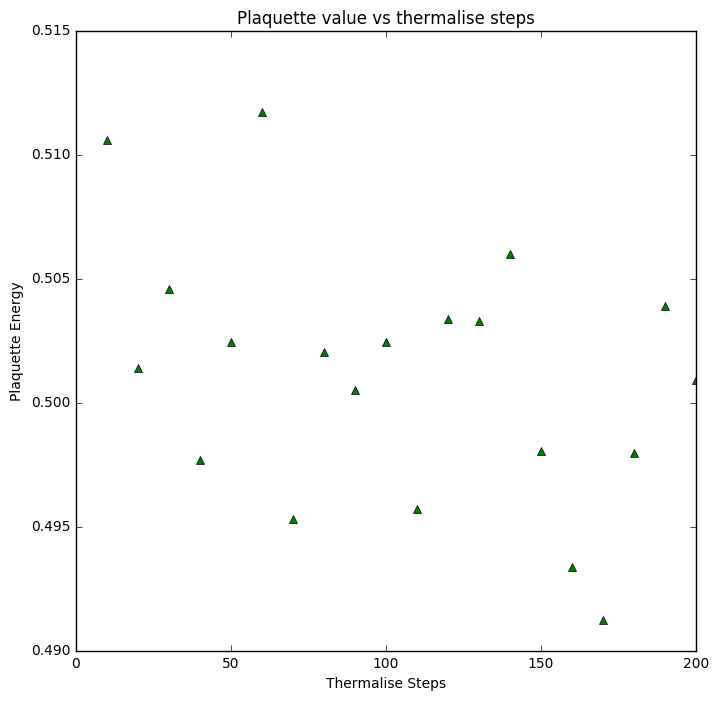

[0.51060313984657457,
 0.5013847157670942,
 0.5045687617050626,
 0.49767233040547437,
 0.50243842450835441,
 0.51172699171719505,
 0.49532175909975795,
 0.50203890527839223,
 0.50052392371228194,
 0.50242030361049828,
 0.49568832180973443,
 0.50338399234014197,
 0.50329714339615139,
 0.50596842623960581,
 0.49805989903980008,
 0.49335166582400802,
 0.49124859803406712,
 0.49798087247881784,
 0.50388724166864685,
 0.50091785732320759]

In [11]:
plaquette_plot_thermal(10)

### Plaquette energy vs thermalsteps for 2 hits

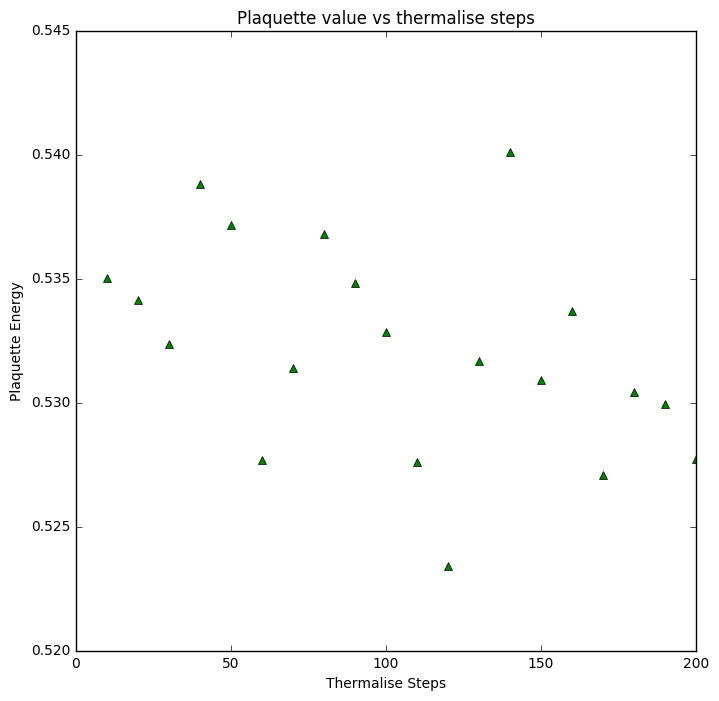

[0.53502768724008543,
 0.53414250972615673,
 0.53236716850917865,
 0.53879576864836853,
 0.53715750876751944,
 0.52767372286305236,
 0.53137677573941822,
 0.53679637736171693,
 0.53482827273185041,
 0.53284371256799534,
 0.52758343669101049,
 0.52342111089003551,
 0.53167697501952549,
 0.5401159570340075,
 0.53092428073951514,
 0.53367114046187425,
 0.52707528292225547,
 0.53043475744588453,
 0.52994744050759113,
 0.52771485820382646]

In [12]:
plaquette_plot_thermal(2)

In [2]:
def plaquette_energy_hits(hits, thermal_steps):
    
    latt = generate_lattice(n_points = 6)

    ensemble, acceptance1 = markov_chain(lattice = latt, link_sum = wilson_link_sum, su3_set = su3_array, 
                                         beta = 5.5, u_0 = 1, n_configs = 20, n_corr = 50, n_hits = hits, 
                                         thermal_steps = thermal_steps)
    
    wilson_square_loop = gauge_average(ensemble, square_lattice_average)[0]
    
    del latt
    
    return wilson_square_loop


def plaquette_plot_hits(thermal_steps):
    p = Pool(5)
    
    plaq_func = partial(plaquette_energy_hits, thermal_steps = thermal_steps)
    hit_arr = range(1, 20)
    energy_array = p.map(plaq_func, hit_arr)

    f, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.plot(hit_arr, energy_array, 'g^')
    ax.set_title('Plaquette value vs hits')
    ax.set_xlabel("Hits")
    ax.set_ylabel("Plaquette Energy")
    plt.show()
    
    p.terminate()
    
    return energy_array

#### Plaquete value vs hits for 100 thermal steps

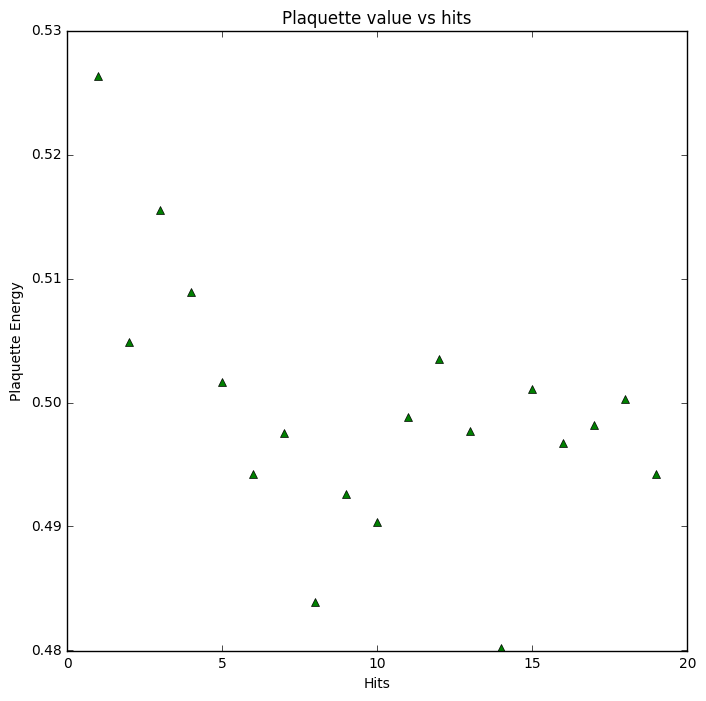

[0.52636062584041687,
 0.50486037998613942,
 0.51553331208846009,
 0.50889909418046575,
 0.50167783515657471,
 0.49427074866346954,
 0.49752447547821654,
 0.48389083301571689,
 0.49261830125144462,
 0.49039153070411989,
 0.49879593463680971,
 0.50350883139571789,
 0.49766954374132916,
 0.48017809399214767,
 0.50105765237079802,
 0.49675550314715988,
 0.49820567206950128,
 0.50027259916373024,
 0.4942020510610986]

In [ ]:
plaquette_plot_hits(100)

#### Plaquete value vs hits for 1000 thermal steps

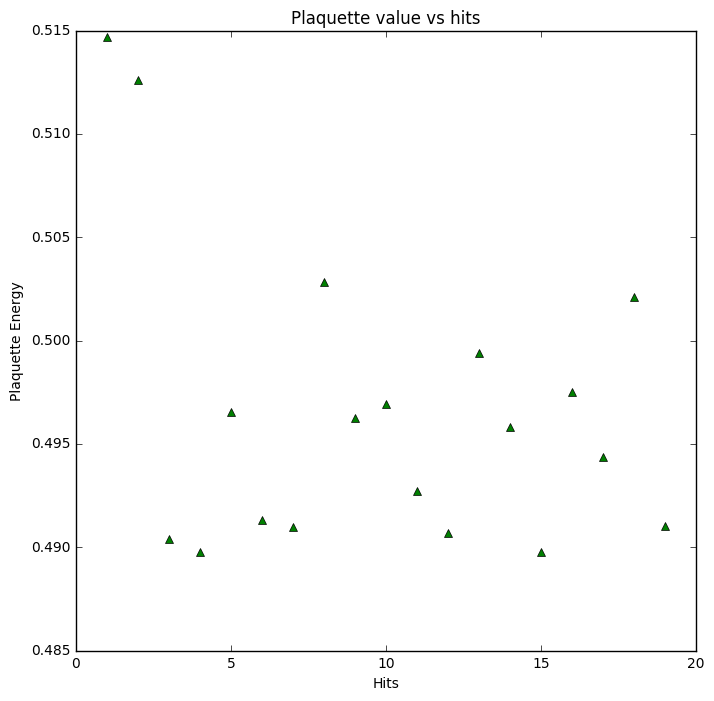

[0.51468397484446204,
 0.512617280461514,
 0.49037748310552204,
 0.48976695901777062,
 0.49654391686138127,
 0.49129189919140542,
 0.49098926541772886,
 0.50281267068366164,
 0.4962532408375025,
 0.49690841211436537,
 0.49271260428416275,
 0.49067341506522466,
 0.4993921674816873,
 0.49582546001412264,
 0.48978928686243484,
 0.49753080180216919,
 0.49436606993548998,
 0.50208378145492216,
 0.49103512151271966]

In [12]:
plaquette_plot_hits(1000)

In [13]:
def plaquette_energy_corr(corr):
    
    latt = generate_lattice(n_points = 6)

    ensemble, acceptance1 = markov_chain(lattice = latt, link_sum = wilson_link_sum, su3_set = su3_array, 
                                         beta = 5.5, u_0 =1,  n_configs = 20, n_corr = corr, n_hits = 10)
    
    wilson_square_loop = gauge_average(ensemble, square_lattice_average)[0]
    
    del latt
    
    return wilson_square_loop


def plaquette_plot_corr():
    p = Pool(5)
    

    beta_arr = range(1, 70, 5)
    energy_array = p.map(plaquette_energy_corr, beta_arr)

    f, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.plot(beta_arr, energy_array, 'g^')
    ax.set_title('Plaquette value vs correlation number')
    ax.set_xlabel("Correlation number")
    ax.set_ylabel("Plaquette Energy")
    plt.show()
    
    p.terminate()
    
    return energy_array

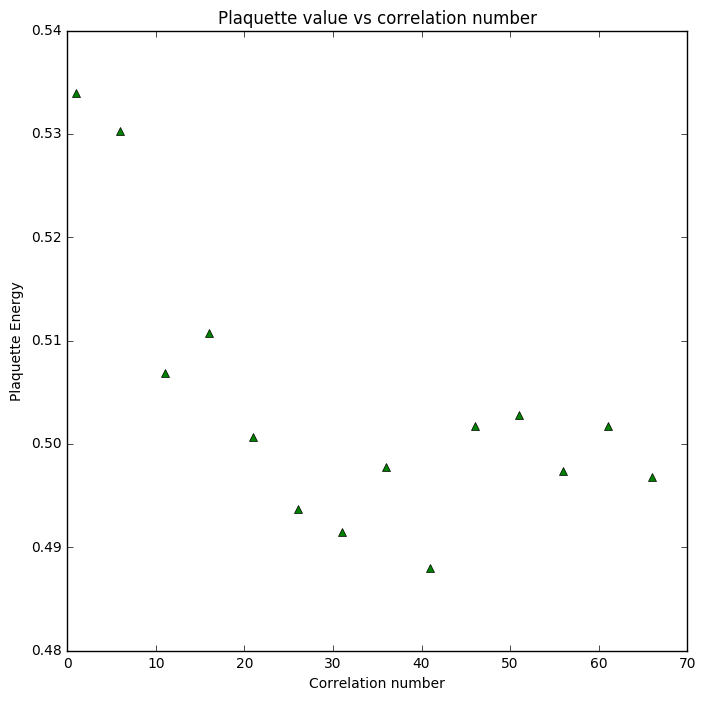

[0.53396062221812268,
 0.53028953621916819,
 0.50686754671838286,
 0.51073250094227118,
 0.50070580276099919,
 0.49366817342435476,
 0.49149366230960057,
 0.497761170426055,
 0.48797173347507333,
 0.50173190755810571,
 0.50276885366846336,
 0.49734688792202641,
 0.50171180568431706,
 0.49674416611198946]

In [14]:
plaquette_plot_corr()

In [11]:
def plaquette_energy_beta(beta):
    
    latt = generate_lattice(n_points = 8)

    ensemble, acceptance1 = markov_chain(lattice = latt, link_sum = wilson_link_sum, su3_set = su3_array, 
                                         beta = beta, u_0=1, n_configs = 20, n_corr = 50, n_hits = 10)
    
    wilson_square_loop = gauge_average(ensemble, square_lattice_average)[0]
    
    del latt
    
    return wilson_square_loop

def plaquette_plot_beta():
    p = Pool(6)
    

    beta_arr = np.linspace(0, 8, 24)
    energy_array = p.map(plaquette_energy_beta, beta_arr)

    f, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.plot(beta_arr, energy_array)
    ax.set_title('Plaquette value vs beta')
    ax.set_xlabel("Beta")
    ax.set_ylabel("Plaquette Energy")
    plt.show()
    
    p.terminate()
    
    return energy_array

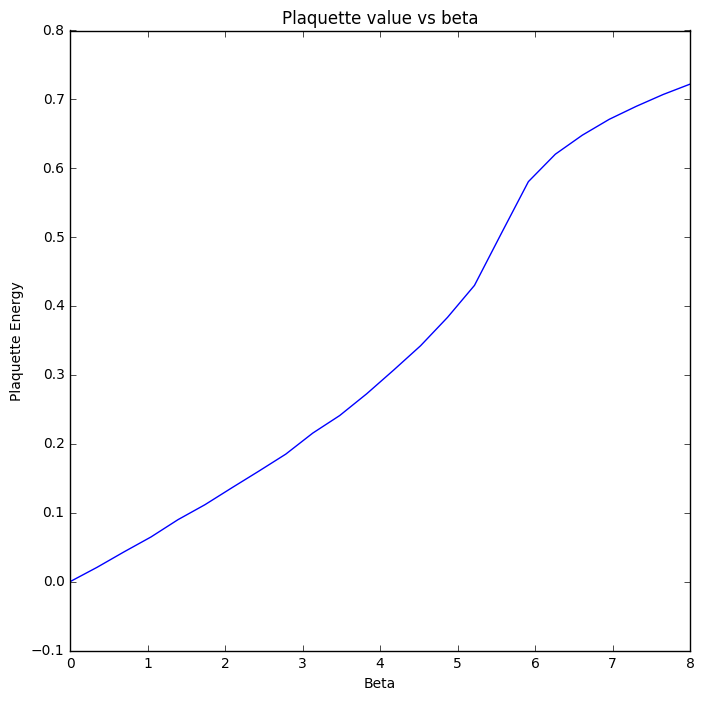

[-2.5636157914491355e-05,
 0.02076918858594597,
 0.043184935515436243,
 0.064809076860467524,
 0.089894581436656823,
 0.11160862968925797,
 0.13618187631715004,
 0.16034877600113268,
 0.18505461476353774,
 0.21555199781471984,
 0.24106872624252657,
 0.27259058160270755,
 0.30699310793020462,
 0.34237952505605301,
 0.38357182391380268,
 0.42998830047116166,
 0.50568414483006596,
 0.5805997749841052,
 0.62043733755026598,
 0.64802339564123712,
 0.67109568911448048,
 0.68990304547454273,
 0.70711539830333847,
 0.72219335508009808]

In [12]:
plaquette_plot_beta()

In [23]:
def plaquette_energy_su3(su3_number):
    
    su3_array = generate_su3_array(su3_number, epsilon = 0.2)
    
    latt = generate_lattice(n_points = 6)

    ensemble, acceptance1 = markov_chain(lattice = latt, link_sum = wilson_link_sum, su3_set = su3_array, 
                                         beta = 5.5, u_0 =1,  n_configs = 50, n_corr = 50, n_hits = 10)
    
    wilson_square_loop = gauge_average(ensemble, square_lattice_average)[0]
    
    del latt
    
    del su3_array
    
    return wilson_square_loop


def plaquette_plot_su3():
    p = Pool(5)
    

    beta_arr = range(25,275,25)
    energy_array = p.map(plaquette_energy_su3, beta_arr)

    f, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.plot(beta_arr, energy_array, 'g^')
    ax.set_title('Plaquette value vs su3_random_matrix_number')
    ax.set_xlabel("Su3 number")
    ax.set_ylabel("Plaquette Energy")
    plt.show()
    
    p.terminate()
    
    return energy_array

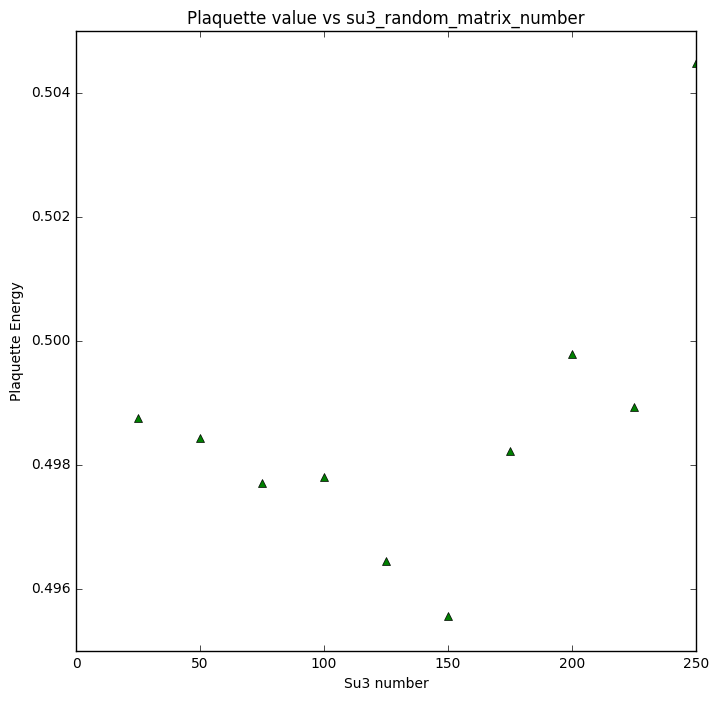

[0.49875554523710719,
 0.49842748070956894,
 0.49769639522696979,
 0.49779404300042274,
 0.4964427139138492,
 0.49555806233174593,
 0.49821395355453918,
 0.49978958926289269,
 0.49892441834556139,
 0.50447470448185061]

In [24]:
plaquette_plot_su3()